In [2]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import wave
#import pyaudio
import numpy as np
#import sounddevice as sd
import cv2
from scipy.signal import iirnotch, filtfilt
from glob import glob

In [3]:
subject_dirs = glob('/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5882302/*')
subject_dirs

['/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5882302/sub-P5882302_task-CUNY_run-001_physio.h5',
 '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5882302/P5882302_20240918_113453.mff',
 '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5882302/sub-P5882302_ses-S001_task-CUNY_run-001_mobi.xdf',
 '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5882302/sub-P5882302_task-CUNY_run-001_behavior.psydat',
 '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5882302/sub-P5882302_task-CUNY_run-001_eyes.csv',
 '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5882302/sub-P5882302_task-CUNY_run-001_video.avi',
 '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5882302/sub-P5882302_task-CUNY_run-001_behavior.csv',
 '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5882302/sub-P5882302_task-CUNY_run-001_behavior.log',
 '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5882302/sub-P5882302_ses-S001_task-CUNY_run-001_mic.wav']

# Load Data

In [4]:
xdf_path =  '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5882302/sub-P5882302_ses-S001_task-CUNY_run-001_mobi.xdf'
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]
streams_collected

['EGI NetAmp 0',
 'OpenSignals',
 'WebcamStream',
 'Tobii',
 'Stimuli_Markers',
 'Microphone']

# Stimulus

In [5]:
stim_dat = data[streams_collected.index('Stimuli_Markers')]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
events = {
    200: 'Onset_ExperimentStart',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_ExperimentEnd',
}

story_onsets = [20, 30, 40, 50, 60, 70]

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 5 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
stim_df['time'] = (stim_dat['time_stamps'] - stim_dat['time_stamps'][0])/1000
stim_df

,trigger,event,lsl_time_stamp,time
0,200,Onset_ExperimentStart,160185.365121,0.000000e+00
1,1726673897,psychopy_time_stamp,160185.365131,9.899959e-09
2,10,Onset_RestingState,160206.491172,2.112605e-02
3,1726673918,psychopy_time_stamp,160206.491181,2.112606e-02
4,11,Offset_RestingState,160506.490719,3.211256e-01
...,...,...,...,...
256,1726676290,psychopy_time_stamp,162578.082491,2.392717e+00
257,201,Offset_ExperimentEnd,162583.073559,2.397708e+00
258,1726676295,psychopy_time_stamp,162583.073578,2.397708e+00
259,4,Bx_input,162583.073738,2.397709e+00


In [6]:
# Function to calculate time between two triggeres

def get_secs_between_triggers(trigger1, trigger2):
    return stim_df.loc[stim_df.trigger == trigger1, 'lsl_time_stamp'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'lsl_time_stamp'].values[0]

In [7]:
# confirm all events are in the stim_df
evs = stim_df.loc[stim_df.event != 'psychopy_time_stamp']
evs

,trigger,event,lsl_time_stamp,time
0,200,Onset_ExperimentStart,160185.365121,0.000000
2,10,Onset_RestingState,160206.491172,0.021126
4,11,Offset_RestingState,160506.490719,0.321126
6,500,Onset_StoryListening,160506.490757,0.321126
8,100,Onset_10second_rest,160565.458067,0.380093
...,...,...,...,...
251,401,Offset_impedanceCheck,162230.974650,2.045610
253,80,Onset_SocialTask,162277.577499,2.092212
255,81,Offset_SocialTask,162578.082477,2.392717
257,201,Offset_ExperimentEnd,162583.073559,2.397708


In [8]:
#Get a list of the story names using the events dict
story_names = [x.split('_')[1] for x in list(events.values())[2:][::2]]
story_names

['RestingState',
 'StoryListening',
 '10second',
 'CampFriend',
 'FrogDissection',
 'DanceContest',
 'ZoomClass',
 'Tornado',
 'BirthdayParty',
 'subjectInput',
 'FavoriteStory',
 'WorstStory',
 'impedanceCheck',
 'SocialTask']

In [9]:
def get_event_data(event, df, stim_df=stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]




# Physio

In [10]:
PS = data[streams_collected.index('OpenSignals')]
# Get the column names
column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
ps_df['lsl_time_stamp'] = PS['time_stamps']
ps_df['time'] = (PS['time_stamps'] - PS['time_stamps'][0])/1000
sampling_rate = int(PS['info']['nominal_srate'][0])

In [11]:
PS

{'info': defaultdict(list,
             {'name': ['OpenSignals'],
              'type': ['00:07:80:8C:06:8C'],
              'channel_count': ['7'],
              'nominal_srate': ['1000'],
              'channel_format': ['float32'],
              'source_id': ['OpenSignals'],
              'version': ['1.1000000000000001'],
              'created_at': ['2233365.7275409'],
              'uid': ['cd9c1c85-8add-453e-9058-5f10a3d17763'],
              'session_id': ['default'],
              'hostname': ['C4-BIOSIGNALS'],
              'v4address': [None],
              'v4data_port': ['16572'],
              'v4service_port': ['16572'],
              'v6address': [None],
              'v6data_port': ['16572'],
              'v6service_port': ['16572'],
              'desc': [defaultdict(list,
                           {'manufacturer': ['OpenSignals'],
                            'channels': [defaultdict(list,
                                         {'channel': [defaultdict(list,
     

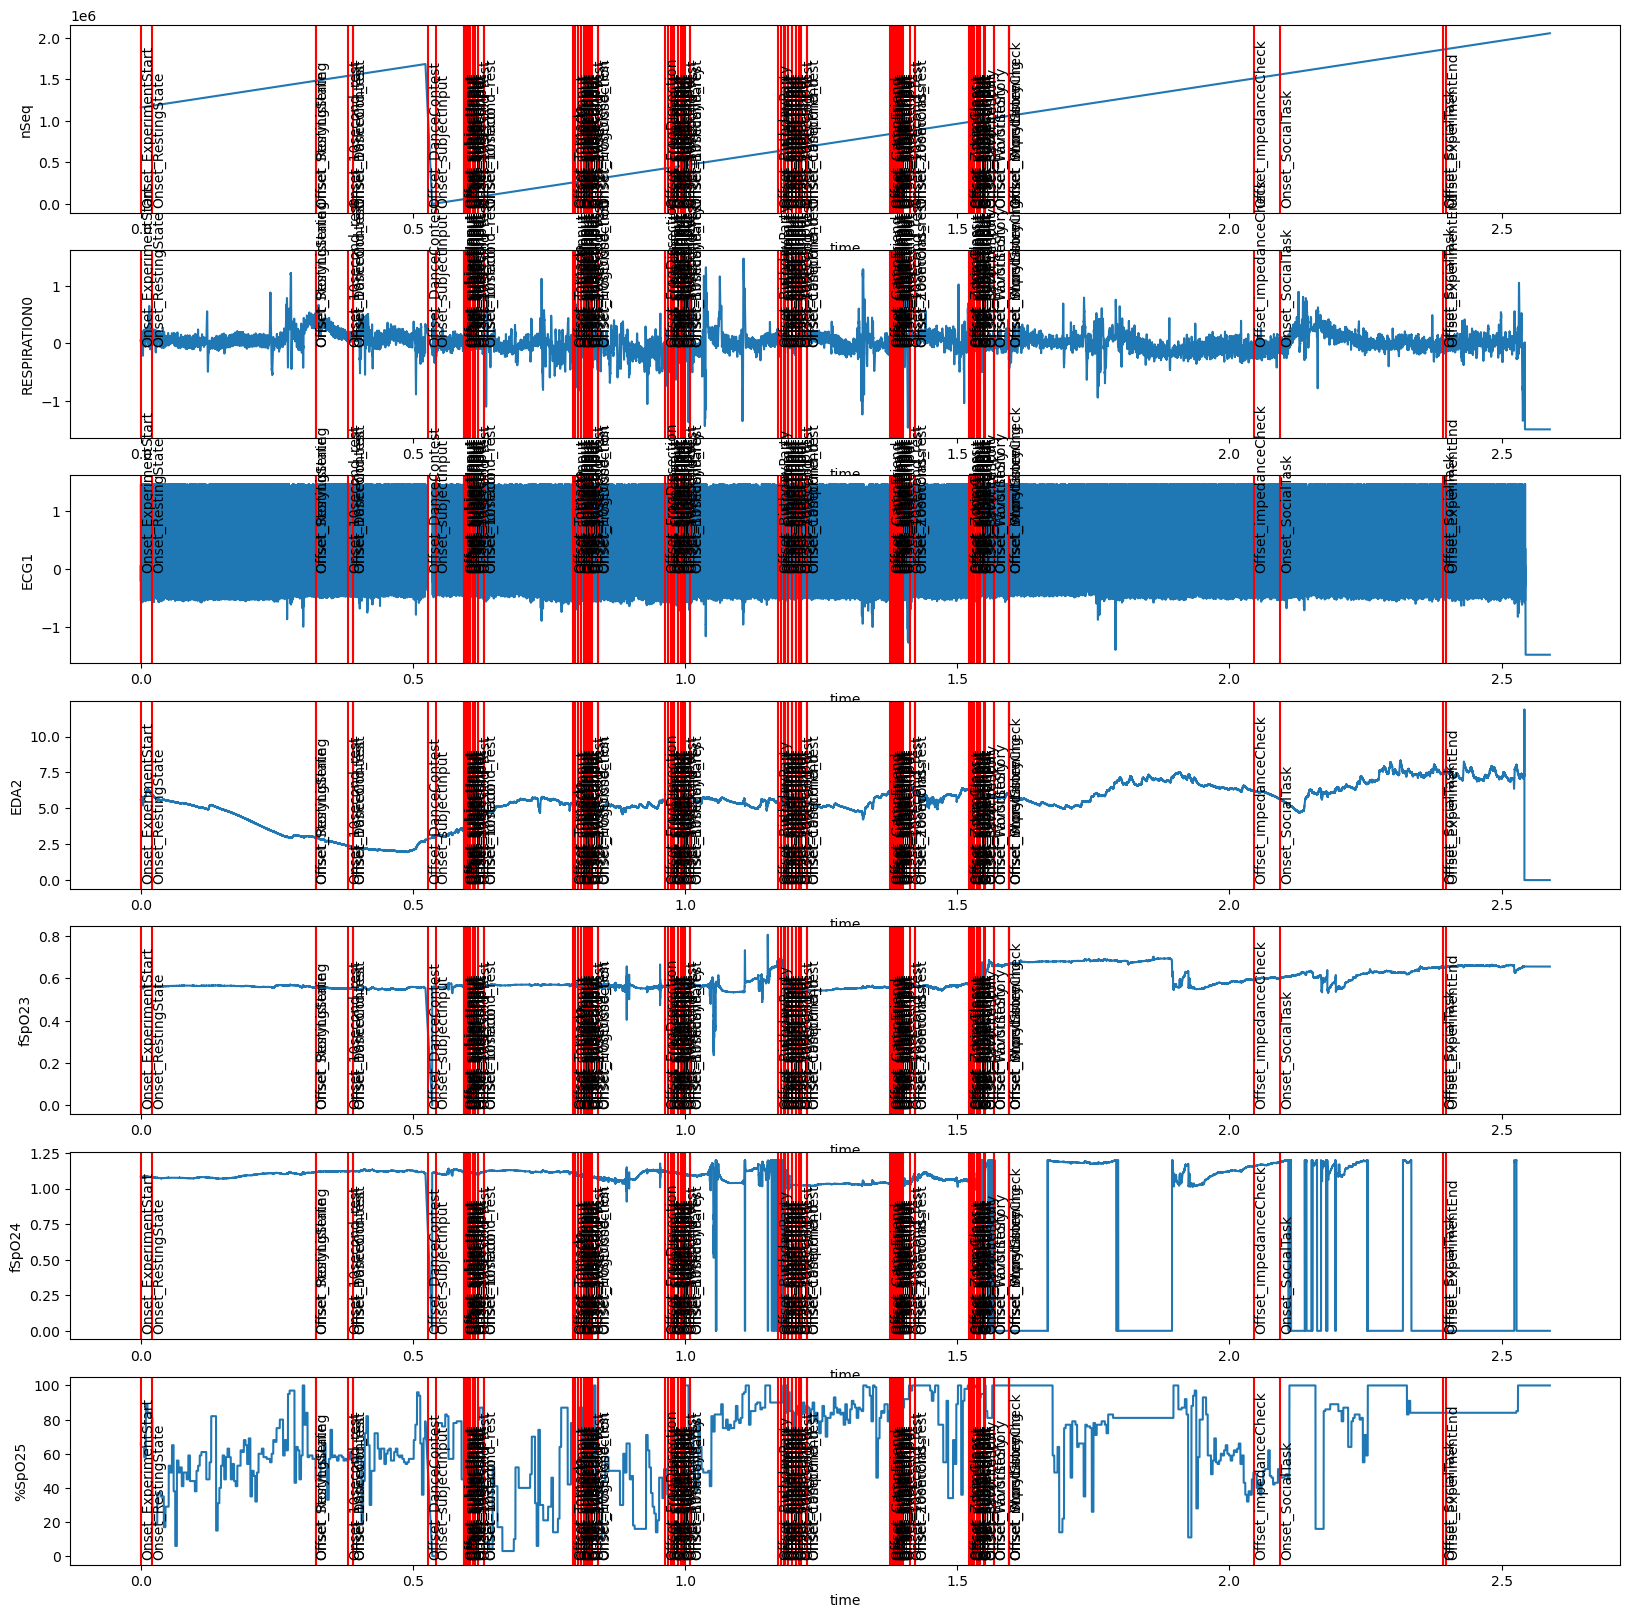

In [12]:
    
'''
# Plot every column in one plot
plt.figure(figsize=(20,10))
for col in ps_df.columns:
    plt.plot(ps_df['time'], ps_df[col])
plt.show()
'''
#f, ax = plt.subplots(figsize=(20,20), nrows=4, ncols=1)
f, ax = plt.subplots(figsize=(20,20), nrows=len(column_labels), ncols=1)

# Make this one figure with subplots
#for i, col in enumerate(['RESPIRATION0', 'fSpO21', 'fSpO22', '%SpO23']):
for i, col in enumerate(column_labels):
    

    #plt.plot(ps_df.loc[(ps_df['time'] > 1000) & (ps_df['time'] < 1015), col])
    #plt.subplot(ps_df['time'], ps_df[col], ax= ax[i])
    sns.lineplot(data=ps_df, x='time', y=col, ax=ax[i])

    # Place and Vline at every event in evs with onset and offset
    for event in evs.iterrows():
        # If the word Onset or Offset is in the event, plot a vertical line at the time of the event

        if "Onset" in event[1]['event'] or "Offset" in event[1]['event']:
            ax[i].axvline(event[1]['time'], color='r')
            ax[i].text(event[1]['time'], 0, event[1]['event'], rotation=90)
        
    #plt.title(col)
    #plt.show()

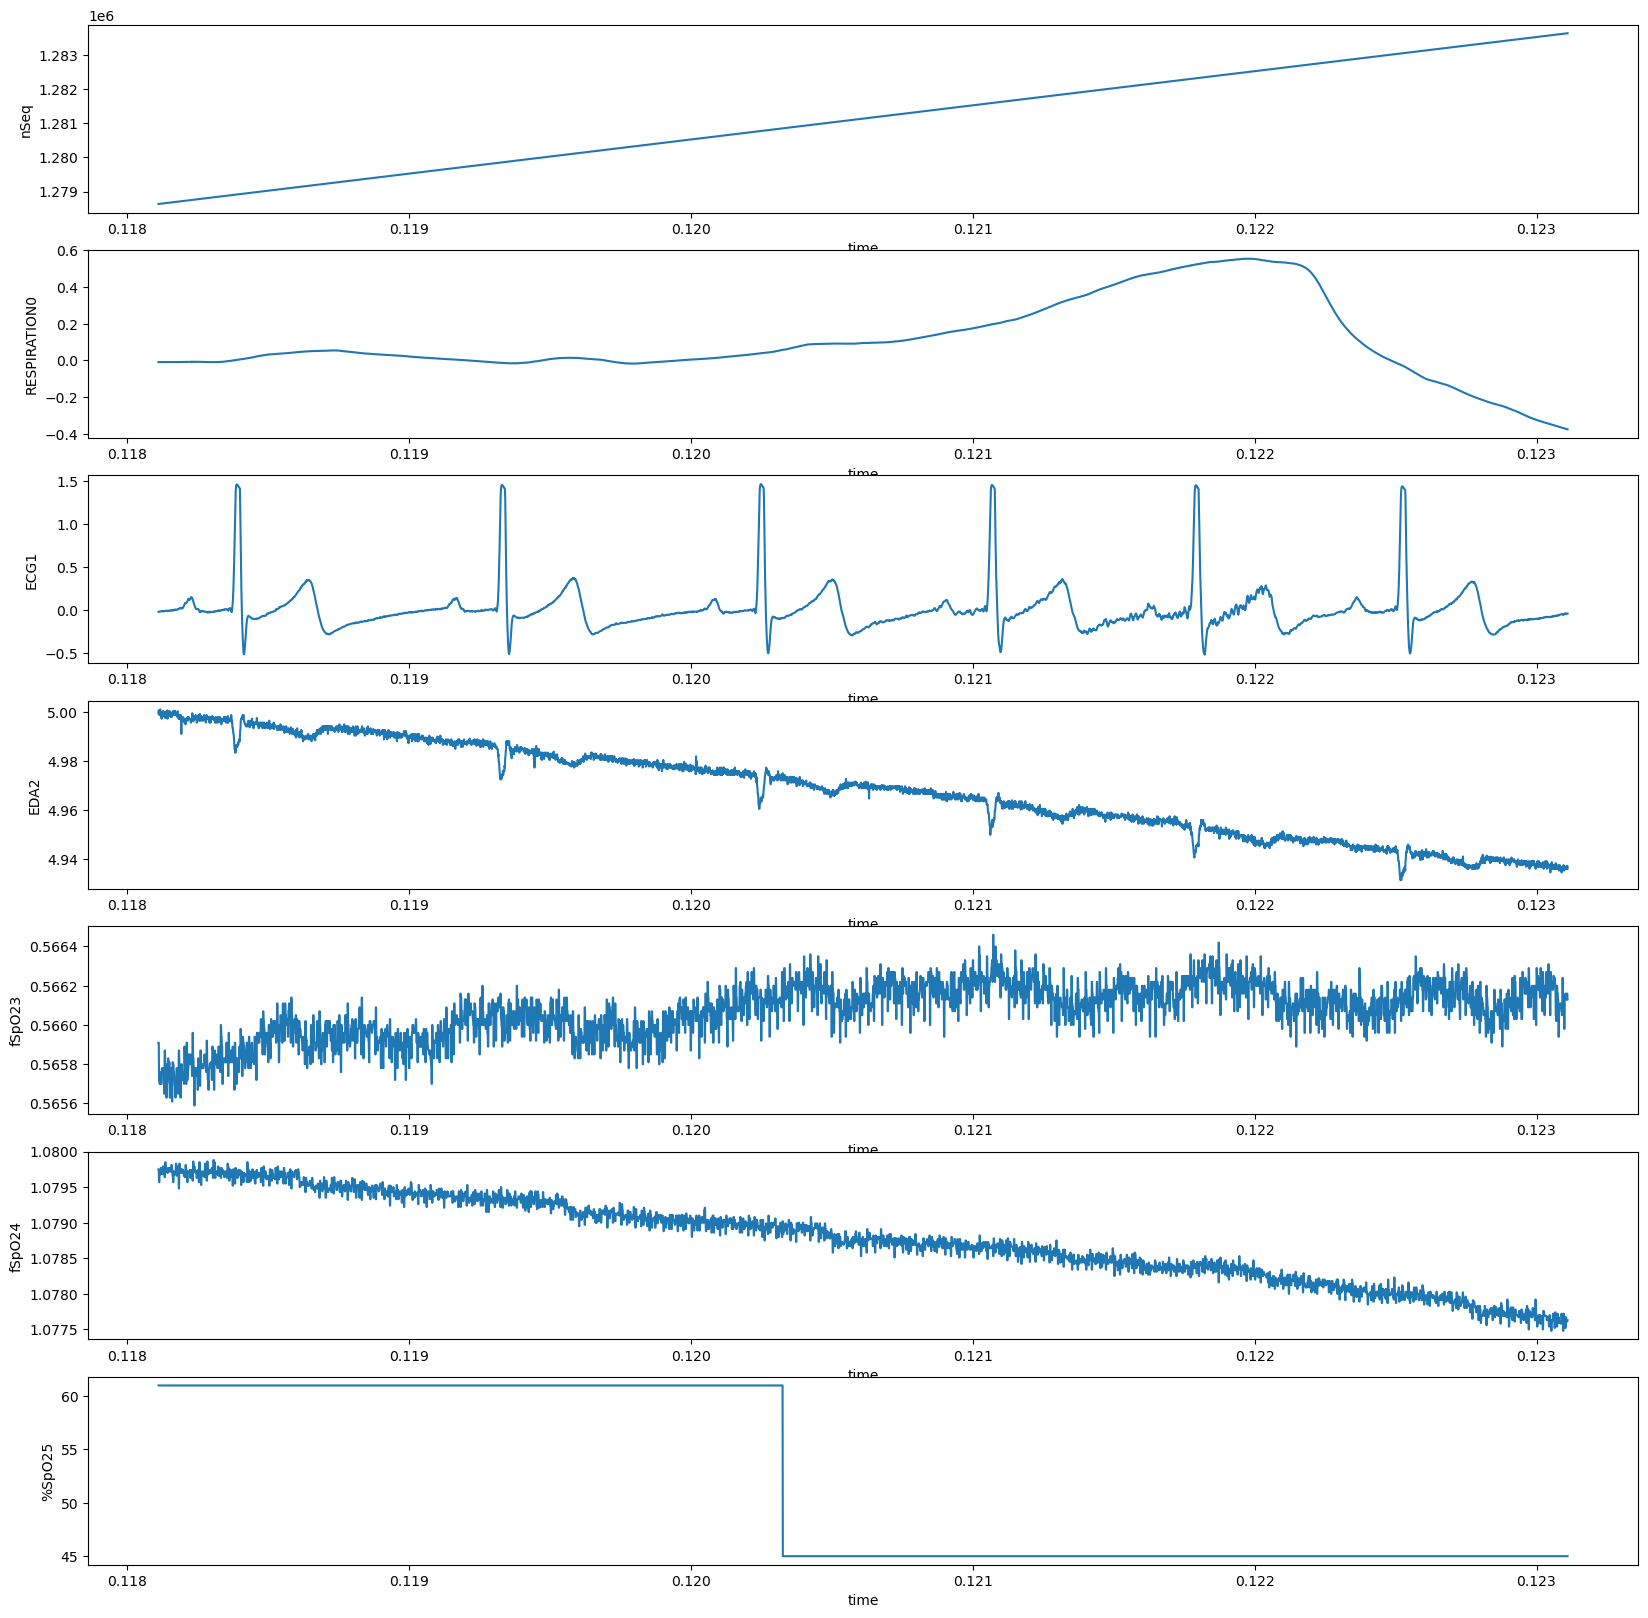

In [13]:
physio_resting_state = get_event_data('RestingState', ps_df)
fig, ax = plt.subplots(figsize=(20,20), nrows=len(column_labels), ncols=1)

# Make this one figure with subplots
#for i, col in enumerate(['RESPIRATION0', 'fSpO21', 'fSpO22', '%SpO23']):
for i, col in enumerate(column_labels):
    

    #plt.plot(ps_df.loc[(ps_df['time'] > 1000) & (ps_df['time'] < 1015), col])
    #plt.subplot(ps_df['time'], ps_df[col], ax= ax[i])
    sns.lineplot(data=physio_resting_state[:5000], x='time', y=col, ax=ax[i])

## ECG

<Axes: xlabel='time', ylabel='ECG1'>

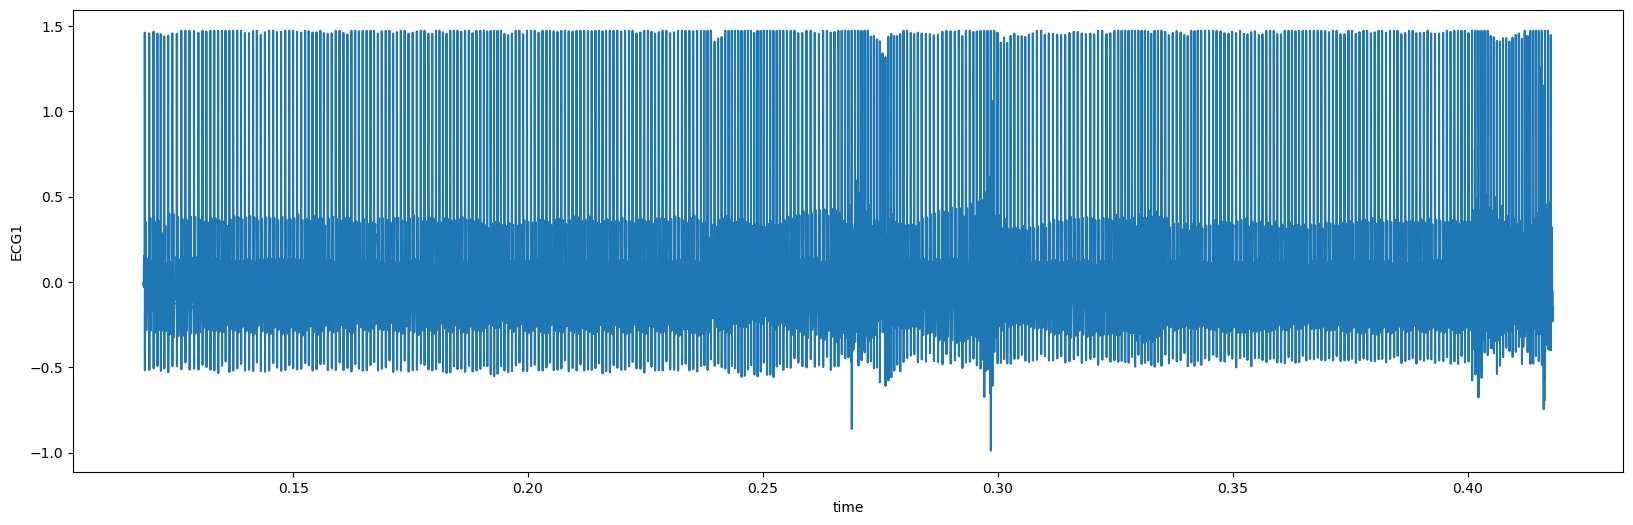

In [16]:
ecg_df = ps_df[['ECG1', 'lsl_time_stamp', 'time']]
ecg_resting_state = get_event_data('RestingState', ecg_df)
fig, ax = plt.subplots(figsize=(20,6))
sns.lineplot(data=ecg_resting_state, x='time', y='ECG1')


### Pacakge: py-ecg-detectors

In [19]:
from ecgdetectors import Detectors
detectors = Detectors(PS['info']['nominal_srate'][0])
unfiltered_ecg = np.array(ecg_df['ECG1'], dtype=float)

In [ ]:
ecg_df = ecg_df.dropna(subset=['ECG1'])
r_peaks = detectors.hamilton_detector(unfiltered_ecg)

In [ ]:
r_peaks = detectors.christov_detector(unfiltered_ecg)

In [ ]:
r_peaks = detectors.pan_tompkins_detector(unfiltered_ecg)

### Pacakge: neurokit2

In [17]:
import neurokit2 as nk

#### ecg_process() - automated pipeline for preprocessing ECG signal, cleaning uses neurokit method

In [18]:
ecg_signals, info = nk.ecg_process(ecg_resting_state['ECG1'], sampling_rate=sampling_rate)
ecg_signals

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,-0.02192,-0.025667,76.825871,0.875795,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,-0.01923,-0.025162,76.825871,0.875795,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,-0.01869,-0.024665,76.825871,0.875795,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,-0.02022,-0.024182,76.825871,0.875795,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,-0.02013,-0.023707,76.825871,0.875795,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299931,-0.16190,-0.078828,100.671141,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
299932,-0.16325,-0.077151,100.671141,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
299933,-0.16864,-0.075314,100.671141,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
299934,-0.16514,-0.073276,100.671141,0.000000,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


### Heartrate

Average Heartrate:  76.88227592507334


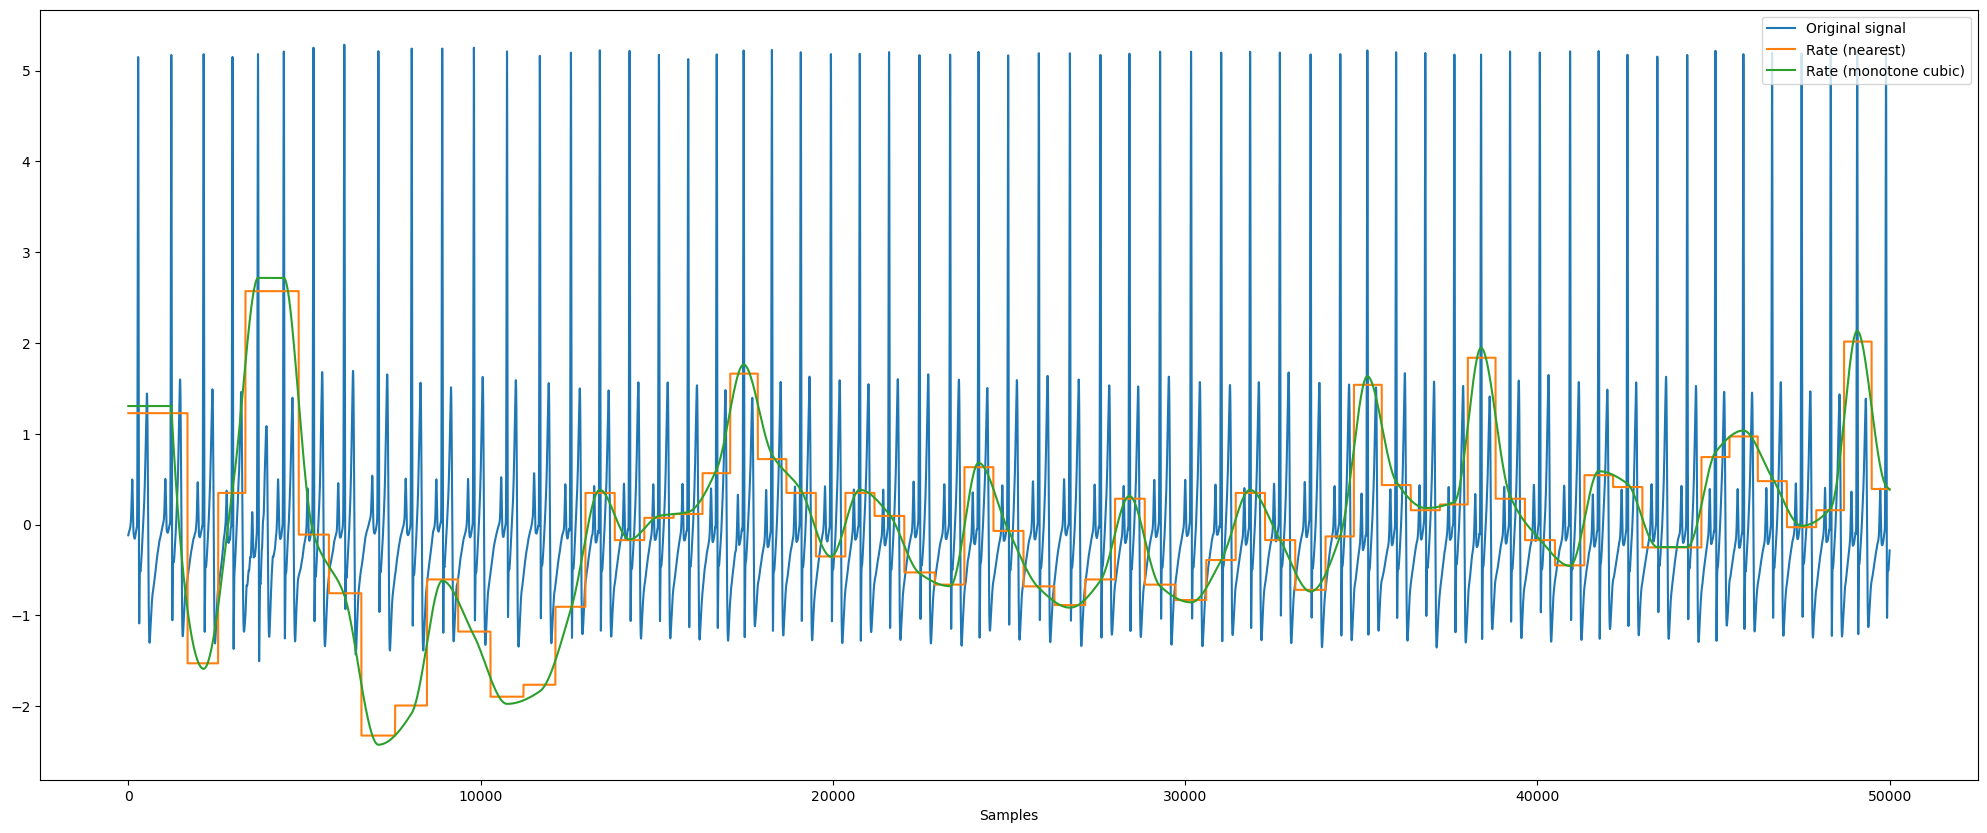

In [27]:
rate1 = nk.signal_rate(
    peaks=info['ECG_R_Peaks'],
    desired_length=len(ecg_signals['ECG_Clean']), 
    interpolation_method='nearest')

rate2 = nk.signal_rate(
    peaks=info['ECG_R_Peaks'],
    desired_length=len(ecg_signals['ECG_Clean']),
    interpolation_method='monotone_cubic')

average_heartrate = sum(rate1)/len(rate1)
print('Average Heartrate: ', average_heartrate)
# Visualization of signal and rate

nk.signal_plot([ecg_signals['ECG_Clean'][:50000], rate1[:50000], rate2[:50000]],
               labels = ["Original signal", "Rate (nearest)", "Rate (monotone cubic)"],
               standardize = True)
fig = plt.gcf()
fig.set_size_inches(25, 10)


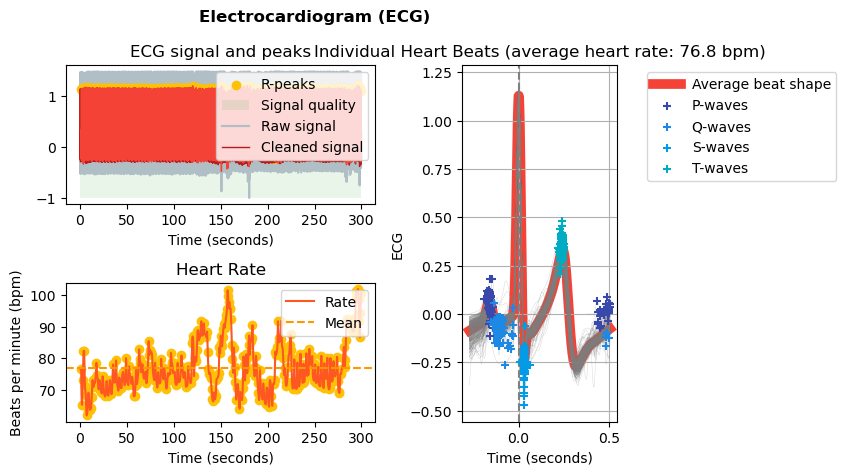

In [28]:
nk.ecg_plot(ecg_signals, info)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.grid(True)      # Add grid for better readability
plt.legend(loc='upper left', bbox_to_anchor=(1.15, 1))  # Move legend outside the plot

# Show the plot
plt.show()

### ECG report plot 

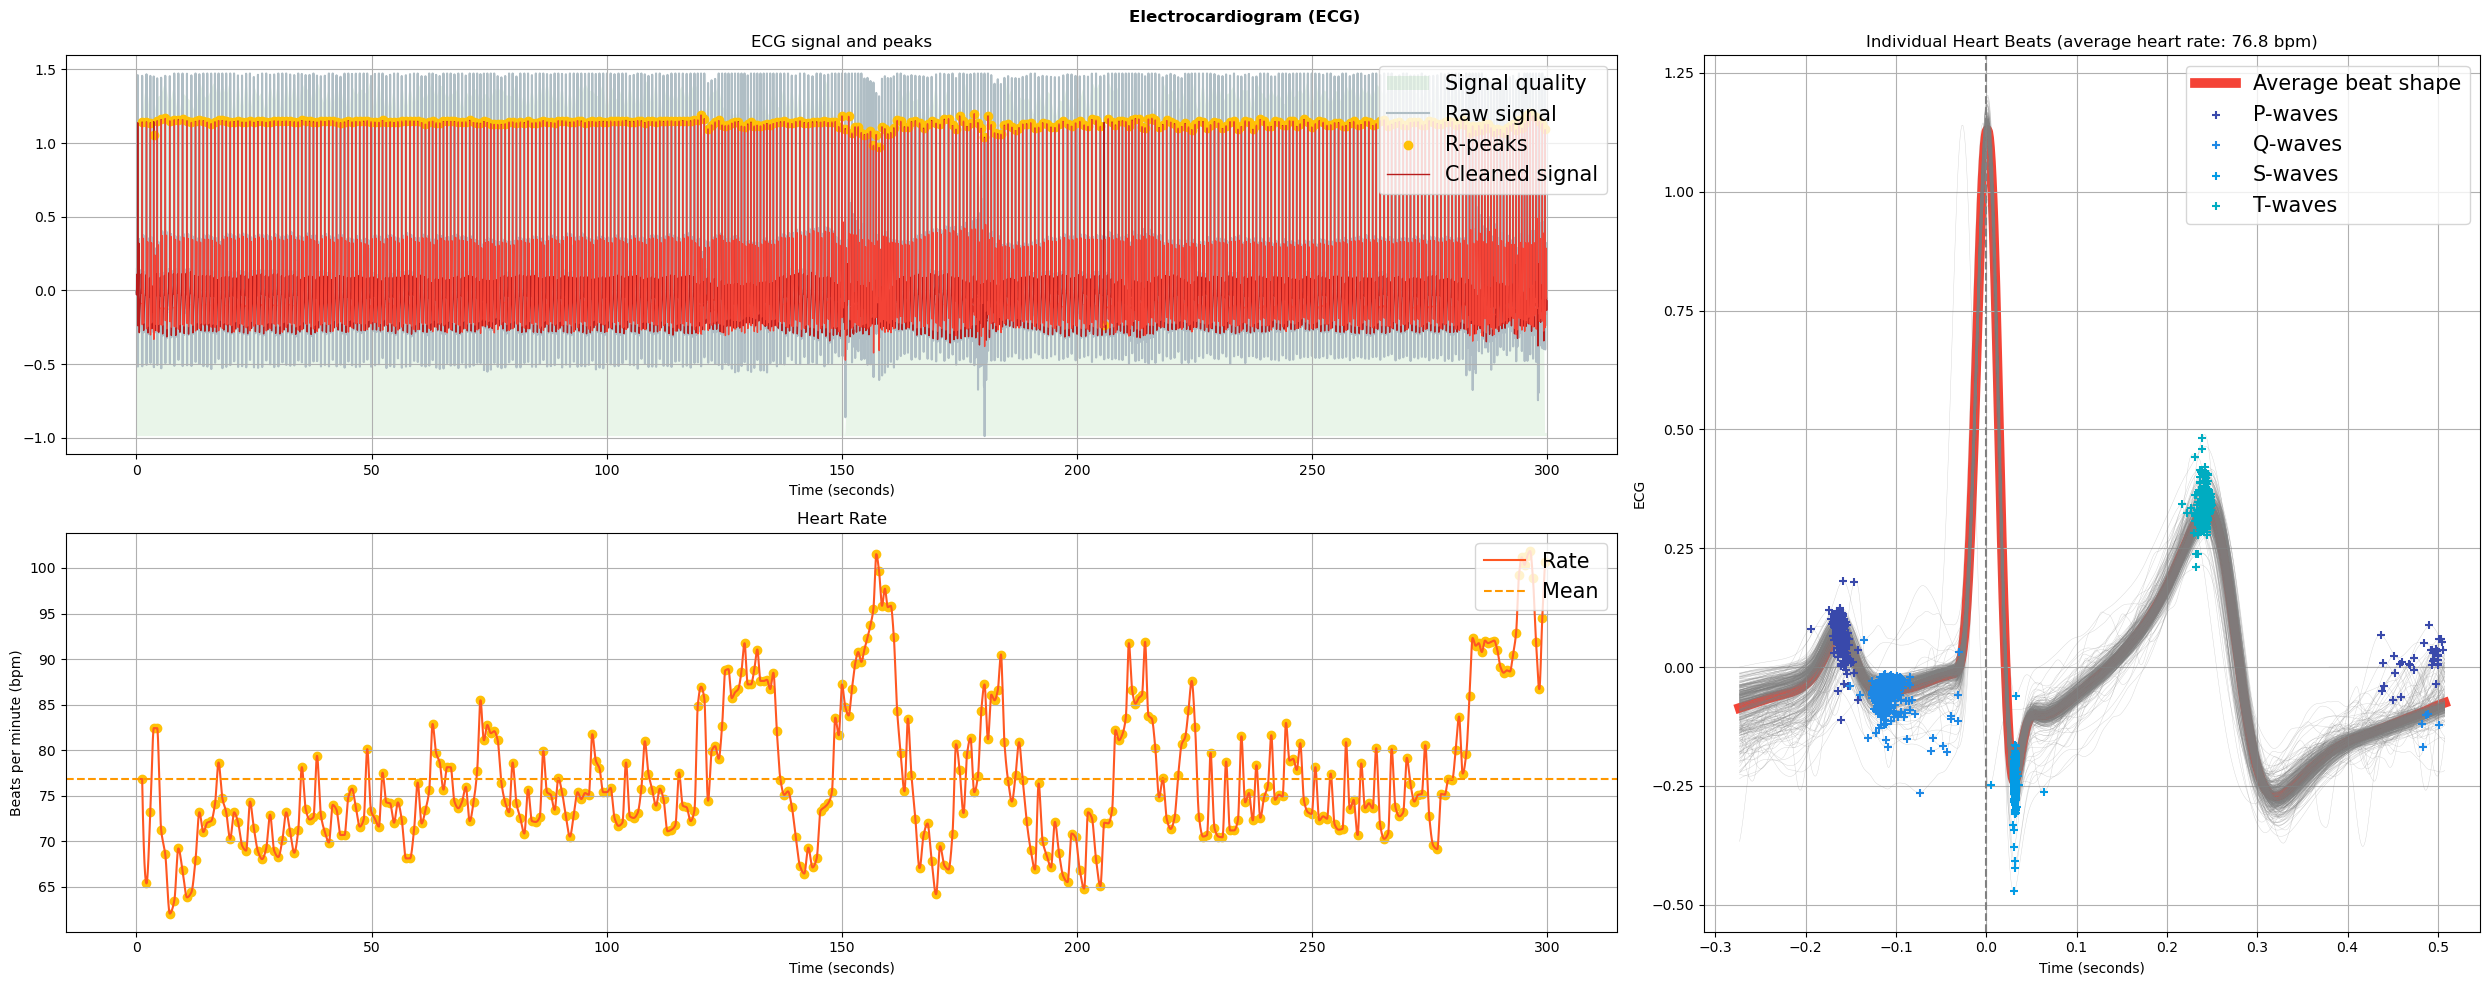

In [29]:
nk.ecg_plot(ecg_signals, info)
# Get the current figure and axes
fig = plt.gcf()
axes = fig.get_axes()
fig.set_size_inches(25, 10)
# Adjust layout to prevent overlap
plt.tight_layout()

# Iterate over each axis and move the legend
for i, ax in enumerate(axes):
    if i == 0:  # Check if it is the first plot (index 0)
        ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=15)  # Move legend outside the plot
    elif i == 1:  # Check if it is the second plot (index 1)
        ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=15)  # Move legend outside the plot
    elif i == 2:  # Check if it is the third plot (index 2)
        ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=15)  # Move legend to the right
    else:
        ax.legend(loc='center right', bbox_to_anchor=(1, 0.5), fontsize=15)  # Default position for other plots


# Add grid for better readability
for ax in axes:
    ax.grid(True)

# Show the plot
plt.show()

### ecg_quality()

In [30]:
ecg_cleaned = nk.ecg_clean(ecg_resting_state['ECG1'], sampling_rate=sampling_rate, method='neurokit')


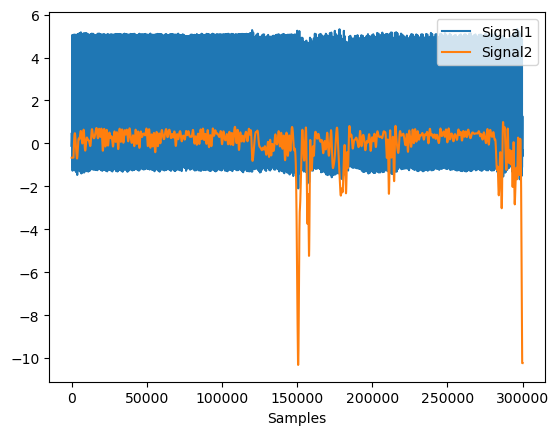

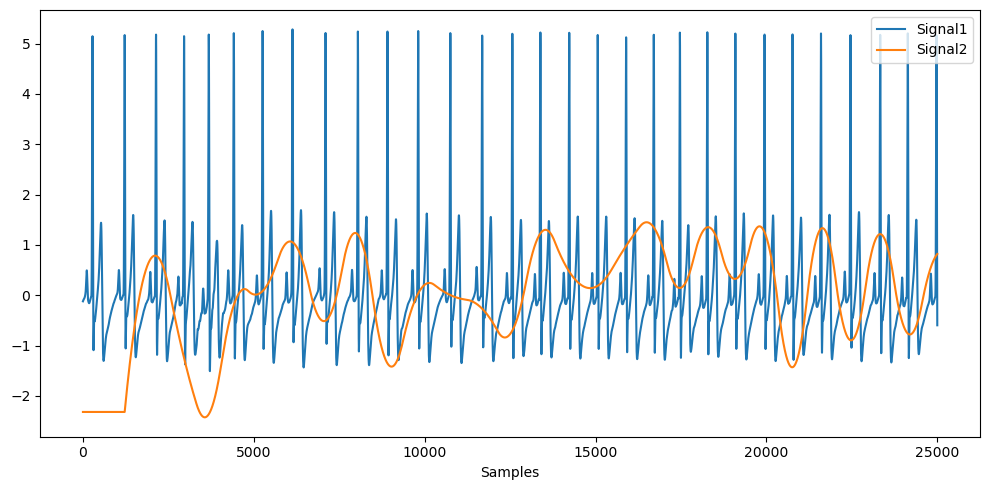

In [31]:
# Average QRS
quality = nk.ecg_quality(ecg_cleaned, sampling_rate=sampling_rate)
nk.signal_plot([ecg_cleaned, quality], standardize=True)

# Magnified plot for average QRS
quality = nk.ecg_quality(ecg_cleaned, sampling_rate=sampling_rate)
nk.signal_plot([ecg_cleaned[:25000], quality[:25000]], standardize=True)
# Get the current figure and axes
fig = plt.gcf()
axes = fig.get_axes()
fig.set_size_inches(10, 5)
# Adjust layout to
#  prevent overlap
plt.tight_layout()

In [32]:
# Zhao 2018 - Calculation of SQIs and Classification using Simple Heuristic fusion method (other method - Fuzzy comprehensive evaluation)
quality = nk.ecg_quality(ecg_cleaned,
               sampling_rate=sampling_rate,
               method="zhao2018",
               approach="simple")
print(quality)

Excellent


### Heart Rate Variability 

In [27]:
r_peaks = nk.ecg_findpeaks(ecg_cleaned, sampling_rate=sampling_rate)

In [28]:
# Calculate the R-R intervals
rr_intervals = info['ECG_R_Peaks']

# Calculate HRV (Standard deviation of R-R intervals)
hrv = nk.hrv(rr_intervals)
print(f"Heart Rate Variability (HRV): {hrv}")


Heart Rate Variability (HRV):    HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  780.986911  75.092995   37.978751   63.704618         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_SampEn  HRV_ShanEn  \
0         NaN         NaN  41.272159  41.317763  ...    1.360798    7.373186   

   HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD   HRV_HFD   HRV_KFD  \
0     0.948409  1.191836   1.355509    1.850465  1.664582  1.672326  2.538887   

    HRV_LZC  
0  0.696074  

[1 rows x 91 columns]


### Extract SQI from ecg_quality() function - kSQI, pSQI, basSQI

In [33]:
import scipy

In [36]:
def _ecg_quality_kSQI(ecg_cleaned, method="fisher"):
    """Return the kurtosis of the signal, with Fisher's or Pearson's method."""

    if method == "fisher":
        return scipy.stats.kurtosis(ecg_cleaned, fisher=True)
    elif method == "pearson":
        return scipy.stats.kurtosis(ecg_cleaned, fisher=False)

kSQI = _ecg_quality_kSQI(ecg_cleaned, method='fisher')
print('kSQI value is: ', kSQI)

kSQI value is:  8.93637089744128


In [37]:
from neurokit2.signal import signal_power

def _ecg_quality_pSQI(
    ecg_cleaned,
    sampling_rate=1000,
    window=1024,
    num_spectrum=[5, 15],
    dem_spectrum=[5, 40],
    **kwargs
):
    """Power Spectrum Distribution of QRS Wave."""

    psd = signal_power(
        ecg_cleaned,
        sampling_rate=sampling_rate,
        frequency_band=[num_spectrum, dem_spectrum],
        method="welch",
        normalize=False,
        window=window,
        **kwargs
    )

    num_power = psd.iloc[0, 0]
    dem_power = psd.iloc[0, 1]

    return num_power / dem_power

pSQI = _ecg_quality_pSQI(ecg_cleaned, sampling_rate=sampling_rate)
print('pSQI value is: ', pSQI)

pSQI value is:  0.7550370862446211


In [38]:
from neurokit2.signal import signal_power

def _ecg_quality_basSQI(
    ecg_cleaned,
    sampling_rate=1000,
    window=1024,
    num_spectrum=[0, 1],
    dem_spectrum=[0, 40],
    **kwargs
):
    """Relative Power in the Baseline."""
    psd = signal_power(
        ecg_cleaned,
        sampling_rate=sampling_rate,
        frequency_band=[num_spectrum, dem_spectrum],
        method="welch",
        normalize=False,
        window=window,
        **kwargs
    )

    num_power = psd.iloc[0, 0]
    dem_power = psd.iloc[0, 1]

    return (1 - num_power) / dem_power

basSQI = _ecg_quality_basSQI(ecg_cleaned, sampling_rate=sampling_rate)
print('basSQI value is: ', basSQI)

basSQI value is:  19.636660400730108


### SNR calculation for ECG

Signal Power: 0.07441513957890625
Noise Power: 0.0011306973479691777
SNR: 18.18314927149259 dB


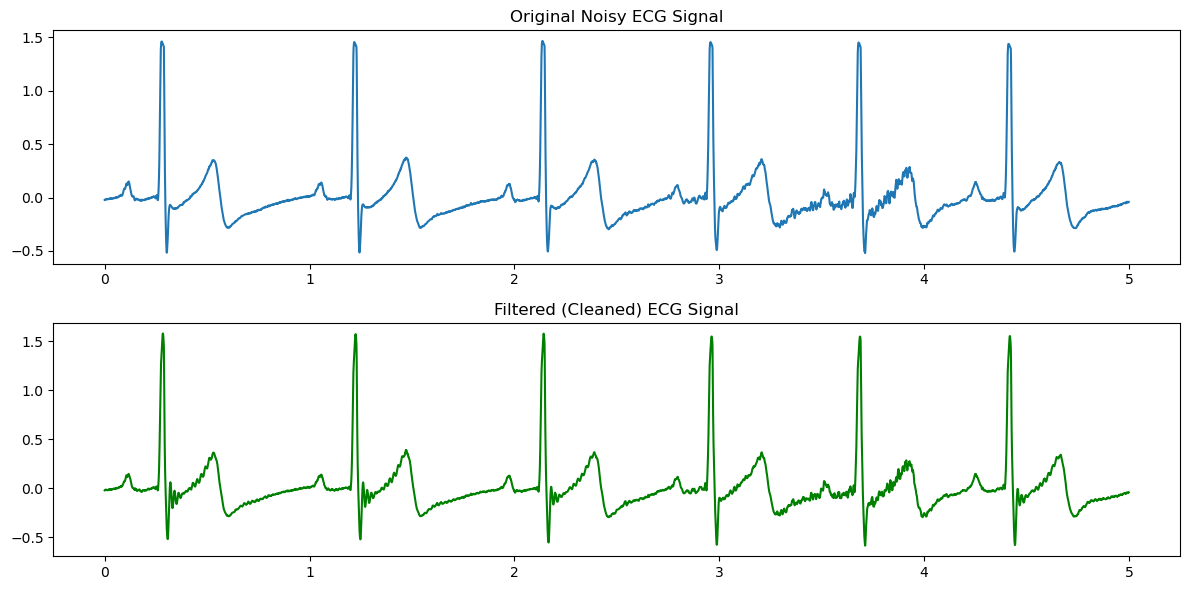

In [39]:
duration = len(ecg_resting_state['ECG1'].tolist()) / sampling_rate
t = np.linspace(0, duration , len(ecg_resting_state['ECG1']))
t = t[:5000]

# Cleaning methods
#ecg_cleaned = nk.ecg_clean(ecg_resting_state['ECG1'], sampling_rate=sampling_rate, method='neurokit') # SNR: 8.487205687259955 dB
#ecg_cleaned = nk.ecg_clean(ecg_resting_state['ECG1'], sampling_rate=sampling_rate, method='biosppy') # SNR: 16.373193128889024 dB
#ecg_cleaned = nk.ecg_clean(ecg_resting_state['ECG1'], sampling_rate=sampling_rate, method='hamilton2002') # SNR: -3.1031182571745024 dB
ecg_cleaned = nk.ecg_clean(ecg_resting_state['ECG1'], sampling_rate=sampling_rate, method='engzeemod2012') # SNR: 18.18314927149259 dB

# Step 3: Calculate signal power (variance of the cleaned ECG signal)
signal_power = np.var(ecg_cleaned)

# Calculate signal power (mean of squared values)
#signal_power = np.mean(ecg_cleaned**2)

# Step 4: Estimate noise power (using residual noise after subtracting cleaned signal from noisy signal)
noise_signal = ecg_resting_state['ECG1'] - ecg_cleaned  # residual noise
noise_power = np.var(noise_signal)
# Calculate noise power (mean of squared values)
#noise_power = np.mean(noise_signal**2)

# Step 5: Calculate SNR (Signal-to-Noise Ratio in dB)
snr = 10 * np.log10(signal_power / noise_power)

# Output the results
print(f"Signal Power: {signal_power}")
print(f"Noise Power: {noise_power}")
print(f"SNR: {snr} dB")

# Optional: Plot the original noisy signal and the cleaned ECG signal for visualization
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, ecg_resting_state['ECG1'].tolist()[:5000], label="Noisy ECG")
plt.title("Original Noisy ECG Signal")
plt.subplot(2, 1, 2)
plt.plot(t, ecg_cleaned[:5000], label="Cleaned ECG", color='g')
plt.title("Filtered (Cleaned) ECG Signal")
plt.tight_layout()
plt.show()
